In [1]:
from fastai.vision.all import*
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv(r"C:\Users\shubh\Desktop\GI segmentation\train.csv", low_memory = False)
#train

In [3]:
train_df = train.pivot(index = 'id', columns = 'class', values = 'segmentation').reset_index()
#train_df

In [4]:
path = Path('./train') #creates path object of given path
## To get the filenames we'll use a nice helper function provided by fastai called `get_image_files` 
# that collects the filenames of all images within a Path
fnames = get_image_files(path) 
#path, fnames

In [13]:
fnames[0]

Path('train/case101/case101_day20/scans/slice_0001_266_266_1.50_1.50.png')

In [14]:
fnames[0].parts[2] + '_' + fnames[0].parts[4][:10]

'case101_day20_slice_0001'

In [5]:
def get_slice_id(fname):
    return fname.parts[2] + '_' + fname.parts[4][:10]

In [6]:
def rle_decode(mask_rle, shape, color = 1):
    
    s = np.array(mask_rle.split(), dtype = int)
    
    start = s[0::2] - 1
    length = s[1::2]
    end = start + length
    
    if(len(shape) == 3):
        h, w, d = shape
        img = np.zeros((h*w, d), dtype = np.float32)
    else:
        h, w = shape
        img = np.zeros((h*w,), dtype = np.float32)
    
    for lo, hi in zip(start, end):
        img[lo: hi] = color
    
    return img.reshape(shape)

In [7]:
def label_func(fname):
    slice_id = get_slice_id(fname)
    slice_row = train_df.query('id == @slice_id')
    
    w, h = map(lambda x: int(x), fname.parts[-1].split('_')[2:4])
    
    mask = np.zeros((h, w, 3), dtype = np.uint8)
    
    if isinstance(slice_row['large_bowel'].item(), str):
        mask[:,:,0] = rle_decode(slice_row['large_bowel'].item(), shape = (h, w), color = 1)
    
    return mask

In [14]:
dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func, item_tfms = Resize(224))

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


C:\Users\shubh\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


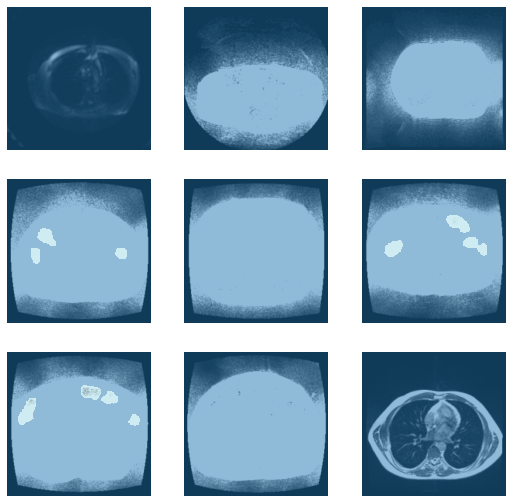

In [9]:
dls.show_batch()

In [8]:
def label_func(fname):
    slice_id = get_slice_id(fname)
    slice_row = train_df.query('id == @slice_id')
    
    w, h = map(lambda x: int(x), fname.parts[-1].split('_')[2:4])
    
    mask = np.zeros((h, w, 3), dtype = np.uint8)
    
    if isinstance(slice_row['large_bowel'].item(), str):
        mask[:, :, 0] = rle_decode(slice_row['large_bowel'].item(), shape = (h, w), color = 1)
    
    if isinstance(slice_row['small_bowel'].item(), str):
        mask[:, :, 0] = rle_decode(slice_row['small_bowel'].item(), shape = (h, w), color = 2)
    
    mask = np.where(mask == 3, 1, mask)
    
    if isinstance(slice_row['stomach'].item(), str):
        mask[:, :, 0] = rle_decode(slice_row['stomach'].item(), shape = (h, w), color = 3)
    
    mask = np.where(mask == 4, 1, mask)
    mask = np.where(mask == 5, 2, mask)
    
    return mask

In [9]:
codes = {1: 'large_bowel', 2: 'small_bowel', 3: 'stomach'}
dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func, codes=codes, item_tfms=Resize(224))

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


C:\Users\shubh\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


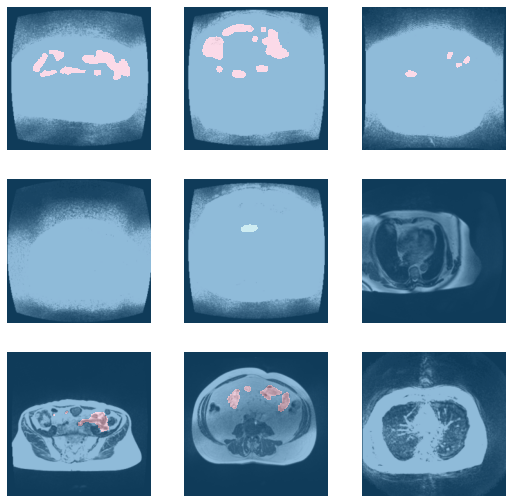

In [12]:
dls.show_batch()

In [10]:
def label_func(fname):
    slice_id = get_slice_id(fname)
    slice_row = train_df.query('id == @slice_id')
    
    w, h = map(lambda x: int(x), fname.parts[-1].split('_')[2:4])
    
    mask = np.zeros((h, w, 3), dtype = np.uint8)
    
    if isinstance(slice_row['large_bowel'].item(), str):
        mask[:, :, 0] = rle_decode(slice_row['large_bowel'].item(), shape = (h, w), color = 255)
    
    if isinstance(slice_row['small_bowel'].item(), str):
        mask[:, :, 0] = rle_decode(slice_row['small_bowel'].item(), shape = (h, w), color = 255)
    
    #mask = np.where(mask == 3, 1, mask)
    
    if isinstance(slice_row['stomach'].item(), str):
        mask[:, :, 0] = rle_decode(slice_row['stomach'].item(), shape = (h, w), color = 255)
    
    #mask = np.where(mask == 4, 1, mask)
    #mask = np.where(mask == 5, 2, mask)
    
    return mask

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


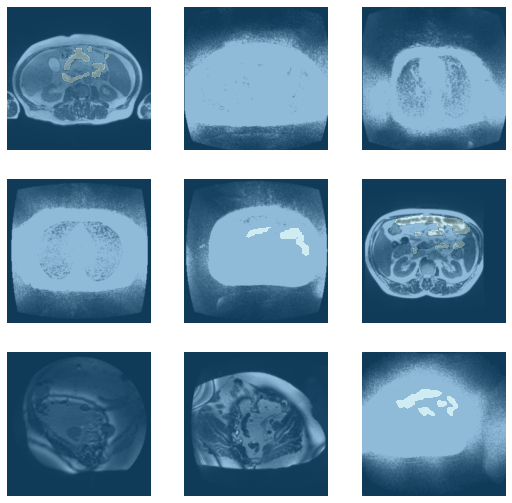

In [11]:
dblock = DataBlock(blocks=(ImageBlock(), MaskBlock()),
                           splitter=RandomSplitter(0.2),
                           get_y=label_func,
                           item_tfms=Resize(224))

dls = dblock.dataloaders(fnames)

dls.show_batch()

In [12]:
@ToTensor
def encodes(self, o:PILMask): return o._tensor_cls(image2tensor(o)[0])

# And this is how we customize it to suit our needs
@ToTensor
def encodes(self, o:PILMask): return o._tensor_cls(image2tensor(o))

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


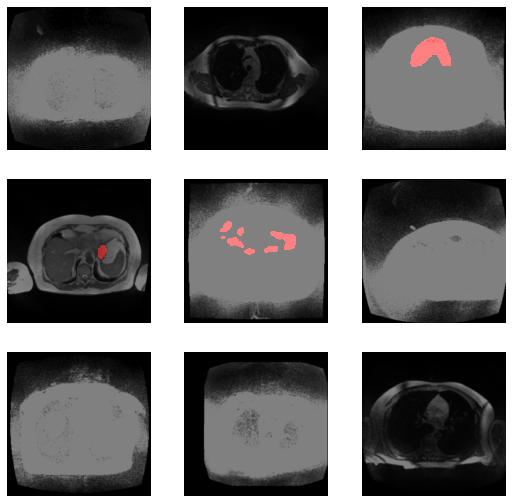

In [16]:
dblock = DataBlock(blocks=(ImageBlock, MaskBlock),
                           splitter=RandomSplitter(0.2),
                           get_y=label_func,
                           item_tfms=Resize(224))

dls = dblock.dataloaders(fnames)

dls.show_batch()

In [13]:
def load_image(fname):
    img = np.array(Image.open(fname))
    img = np.interp(img, [np.min(img), np.max(img)], [0,255])
    return img

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


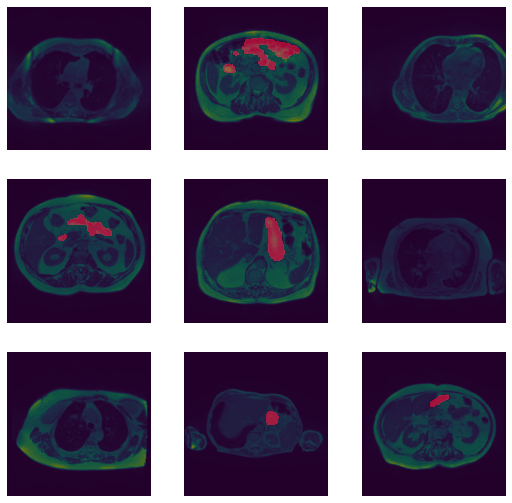

In [21]:
dblock = DataBlock(blocks=(ImageBlock, MaskBlock),
                           splitter=RandomSplitter(0.2),
                           get_x=load_image,
                           get_y=label_func,
                           item_tfms=Resize(224))

dls = dblock.dataloaders(fnames)

dls.show_batch()

In [14]:
import matplotlib.patches as mpatches

@typedispatch
def show_batch(x:TensorImage, y:TensorMask, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*3, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(max_n, nrows=nrows, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        x_i = x[i] / x[i].max()
        show_image(x_i, ctx=ctx, cmap='gray', **kwargs)
        show_image(y[i], ctx=ctx, cmap='Spectral_r', alpha=0.35, **kwargs)
        red_patch = mpatches.Patch(color='red', label='large_bowel')
        green_patch = mpatches.Patch(color='green', label='small_bowel')
        blue_patch = mpatches.Patch(color='blue', label='stomach')
        ctx.legend(handles=[red_patch, green_patch, blue_patch], fontsize=figsize[0]/2)

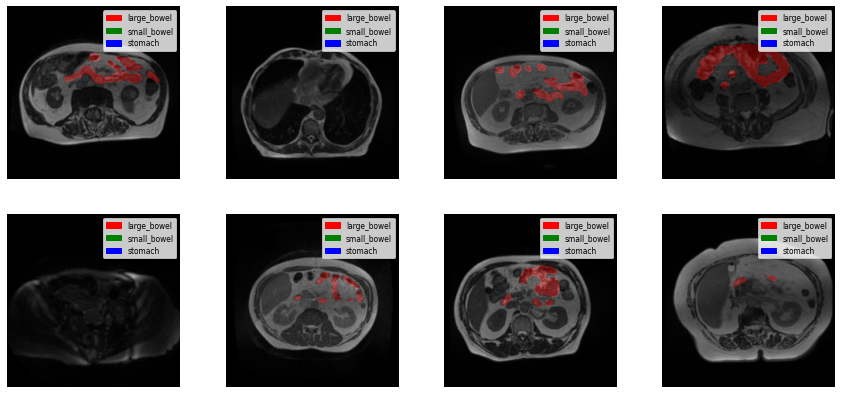

In [20]:
dls.show_batch(nrows=2, ncols=4, figsize=(15, 7))

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


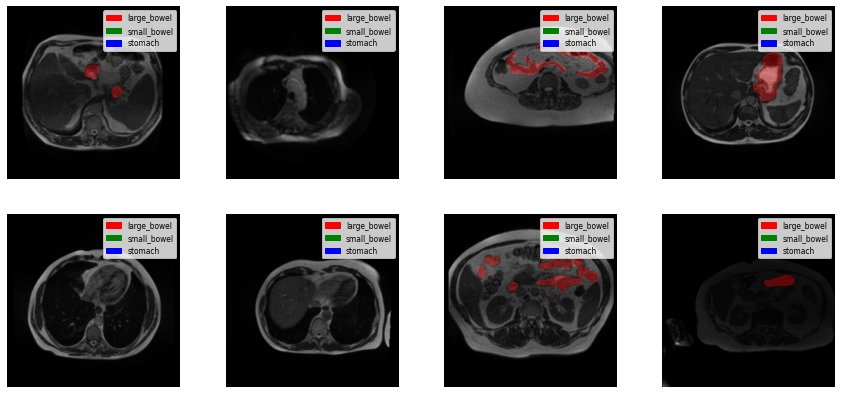

In [15]:
# The list of transformations contain two lists
# 1. The first is for the X part of the dataset (images)
# 2. The second if for the Y part of the dataset (masks)
tfms = [[load_image, PILImageBW.create], [label_func, PILMask.create]]

# Then we just pass the fnames along the transformations
dsets = Datasets(fnames, tfms)

# With the DataBlock API, we didn't worry about passing item and batch transformations
# As some are implicitly used like ToTensor and IntToFloatTensor
# But in here we need to pass them explicitly
dls = dsets.dataloaders(after_item=[Resize(224), ToTensor], after_batch=[IntToFloatTensor])


# Now let's see if our visualization works
dls.show_batch(nrows=2, ncols=4, figsize=(15, 7))

In [16]:
train_df['partial_fname'] = train_df.id
fname_df = pd.DataFrame({'partial_fname': [f'{fname.parts[-3]}_slice_{fname.parts[-1][6:10]}' for fname in fnames],
                         'fname': fnames})

train_df = train_df.merge(fname_df, on='partial_fname').drop('partial_fname', axis=1)

train_df['case_id'] = train_df.id.apply(lambda x: x.split('_')[0])
train_df['day_num'] = train_df.id.apply(lambda x: x.split('_')[1])

train_df['slice_w'] = train_df["fname"].apply(lambda x: int(str(x)[:-4].rsplit("_",4)[1]))
train_df['slice_h'] = train_df["fname"].apply(lambda x: int(str(x)[:-4].rsplit("_",4)[2]))


train_df.head()

id large_bowel small_bowel stomach  \
0  case101_day20_slice_0001         NaN         NaN     NaN   
1  case101_day20_slice_0002         NaN         NaN     NaN   
2  case101_day20_slice_0003         NaN         NaN     NaN   
3  case101_day20_slice_0004         NaN         NaN     NaN   
4  case101_day20_slice_0005         NaN         NaN     NaN   

                                                                fname  \
0  train\case101\case101_day20\scans\slice_0001_266_266_1.50_1.50.png   
1  train\case101\case101_day20\scans\slice_0002_266_266_1.50_1.50.png   
2  train\case101\case101_day20\scans\slice_0003_266_266_1.50_1.50.png   
3  train\case101\case101_day20\scans\slice_0004_266_266_1.50_1.50.png   
4  train\case101\case101_day20\scans\slice_0005_266_266_1.50_1.50.png   

   case_id day_num  slice_w  slice_h  
0  case101   day20      266      266  
1  case101   day20      266      266  
2  case101   day20      266      266  
3  case101   day20      266      266  
4  case101   day20      266      266

In [17]:
channels = 3
stride = 2
for j, i in enumerate(range(-1*(channels-channels//2-1), channels//2+1)):
    method = 'ffill'
    if i <= 0: method = 'bfill'
    train_df[f'fname_{j:02}'] = train_df.groupby(['case_id', 'day_num'])['fname'].shift(stride*-i).fillna(method=method)
    
train_df['fnames'] = train_df[[f'fname_{j:02d}' for j in range(channels)]].values.tolist()

train_df.head()

id large_bowel small_bowel stomach  \
0  case101_day20_slice_0001         NaN         NaN     NaN   
1  case101_day20_slice_0002         NaN         NaN     NaN   
2  case101_day20_slice_0003         NaN         NaN     NaN   
3  case101_day20_slice_0004         NaN         NaN     NaN   
4  case101_day20_slice_0005         NaN         NaN     NaN   

                                                                fname  \
0  train\case101\case101_day20\scans\slice_0001_266_266_1.50_1.50.png   
1  train\case101\case101_day20\scans\slice_0002_266_266_1.50_1.50.png   
2  train\case101\case101_day20\scans\slice_0003_266_266_1.50_1.50.png   
3  train\case101\case101_day20\scans\slice_0004_266_266_1.50_1.50.png   
4  train\case101\case101_day20\scans\slice_0005_266_266_1.50_1.50.png   

   case_id day_num  slice_w  slice_h  \
0  case101   day20      266      266   
1  case101   day20      266      266   
2  case101   day20      266      266   
3  case101   day20      266      266   
4  case101   day20      266      266   

                                                             fname_00  \
0  train\case101\case101_day20\scans\slice_0001_266_266_1.50_1.50.png   
1  train\case101\case101_day20\scans\slice_0001_266_266_1.50_1.50.png   
2  train\case101\case101_day20\scans\slice_0001_266_266_1.50_1.50.png   
3  train\case101\case101_day20\scans\slice_0002_266_266_1.50_1.50.png   
4  train\case101\case101_day20\scans\slice_0003_266_266_1.50_1.50.png   

                                                             fname_01  \
0  train\case101\case101_day20\scans\slice_0001_266_266_1.50_1.50.png   
1  train\case101\case101_day20\scans\slice_0002_266_266_1.50_1.50.png   
2  train\case101\case101_day20\scans\slice_0003_266_266_1.50_1.50.png   
3  train\case101\case101_day20\scans\slice_0004_266_266_1.50_1.50.png   
4  train\case101\case101_day20\scans\slice_0005_266_266_1.50_1.50.png   

                                                             fname_02  \
0  train\case101\case101_day20\scans\slice_0003_266_266_1.50_1.50.png   
1  train\case101\case101_day20\scans\slice_0004_266_266_1.50_1.50.png   
2  train\case101\case101_day20\scans\slice_0005_266_266_1.50_1.50.png   
3  train\case101\case101_day20\scans\slice_0006_266_266_1.50_1.50.png   
4  train\case101\case101_day20\scans\slice_0007_266_266_1.50_1.50.png   

                                                                                                                                                                                                         fnames  
0  [train\case101\case101_day20\scans\slice_0001_266_266_1.50_1.50.png, train\case101\case101_day20\scans\slice_0001_266_266_1.50_1.50.png, train\case101\case101_day20\scans\slice_0003_266_266_1.50_1.50.png]  
1  [train\case101\case101_day20\scans\slice_0001_266_266_1.50_1.50.png, train\case101\case101_day20\scans\slice_0002_266_266_1.50_1.50.png, train\case101\case101_day20\scans\slice_0004_266_266_1.50_1.50.png]  
2  [train\case101\case101_day20\scans\slice_0001_266_266_1.50_1.50.png, train\case101\case101_day20\scans\slice_0003_266_266_1.50_1.50.png, train\case101\case101_day20\scans\slice_0005_266_266_1.50_1.50.png]  
3  [train\case101\case101_day20\scans\slice_0002_266_266_1.50_1.50.png, train\case101\case101_day20\scans\slice_0004_266_266_1.50_1.50.png, train\case101\case101_day20\scans\slice_0006_266_266_1.50_1.50.png]  
4  [train\case101\case101_day20\scans\slice_0003_266_266_1.50_1.50.png, train\case101\case101_day20\scans\slice_0005_266_266_1.50_1.50.png, train\case101\case101_day20\scans\slice_0007_266_266_1.50_1.50.png]

In [18]:
def load_image(fname):
    img = np.array(Image.open(fname))
    img = np.interp(img, [np.min(img), np.max(img)], [0,255])
    return img

def get_25D_image(row):
    imgs = np.zeros((row['slice_h'], row['slice_w'], len(row['fnames'])))
        
    for i, fname in enumerate(row['fnames']):
        img = load_image(fname)
        imgs[..., i] += img
    return imgs.astype(np.uint8)


def get_mask(row):
    mask = np.zeros((row['slice_h'], row['slice_w'], 3))
        
    if isinstance(row['large_bowel'], str):
        mask[..., 0] += rle_decode(row['large_bowel'], shape=(row['slice_h'], row['slice_w']), color=255)
    if isinstance(row['small_bowel'], str):
        mask[..., 1] += rle_decode(row['small_bowel'], shape=(row['slice_h'], row['slice_w']), color=255)
    if isinstance(row['stomach'], str):
        mask[..., 2] += rle_decode(row['stomach'], shape=(row['slice_h'], row['slice_w']), color=255)
        
    return mask.astype(np.uint8)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


C:\Users\shubh\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


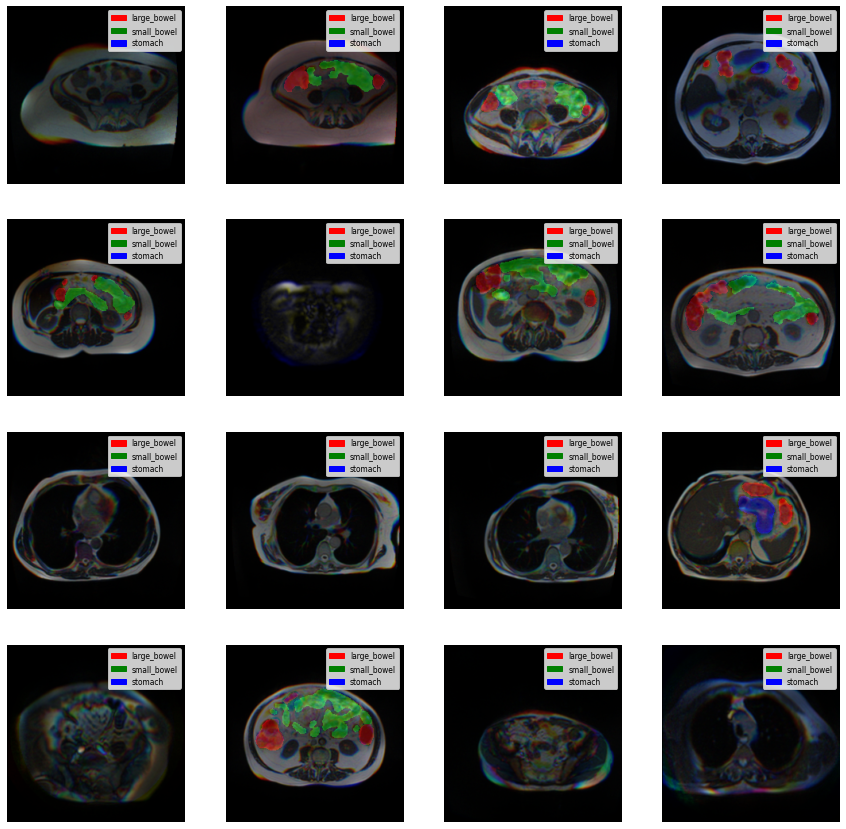

In [19]:
tfms = [[get_25D_image, PILImage.create],
        [get_mask, PILMask.create]]
    
dsets = Datasets(train_df, tfms)

dls = dsets.dataloaders(bs=16, after_item=[Resize(224), ToTensor], after_batch=[IntToFloatTensor])

# Now let's see if our visualization works
dls.show_batch(nrows=4, ncols=4, max_n=16, figsize=(15, 15))

In [20]:
def pad_img(img, up_size=None):
    if up_size is None:
        return img
    shape0 = np.array(img.shape[:2])
    resize = np.array(up_size)
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        img = np.pad(img, [pady, padx])
        img = img.reshape((*resize,))
    return img


def unpad_img(img, up_size, org_size):
    shape0 = np.array(org_size)
    resize = np.array(up_size)
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        img = img[pady[0]:-pady[1], padx[0]:-padx[1], :]
        img = img.reshape((*shape0, 3))
    return img

    
def load_image(fname, up_size=None):
    img = np.array(Image.open(fname))
    img = np.interp(img, [np.min(img), np.max(img)], [0,255])
    return pad_img(img, up_size)

def get_25D_image(row, up_size=None):
    if up_size:
        imgs = np.zeros((*up_size, len(row['fnames'])))
    else:
        imgs = np.zeros((row['slice_h'], row['slice_w'], len(row['fnames'])))
        
    for i, fname in enumerate(row['fnames']):
        img = load_image(fname, up_size)
        imgs[..., i] += img
    return imgs.astype(np.uint8)
                   

def get_mask(row, up_size=None):
    if up_size:
        mask = np.zeros((*up_size, 3))
    else:
        mask = np.zeros((row['slice_h'], row['slice_w'], 3))
        
    if isinstance(row['large_bowel'], str):
        mask[..., 0] += pad_img(rle_decode(row['large_bowel'], shape=(row['slice_h'], row['slice_w']), color=255), up_size)
    if isinstance(row['small_bowel'], str):
        mask[..., 1] += pad_img(rle_decode(row['small_bowel'], shape=(row['slice_h'], row['slice_w']), color=255), up_size)
    if isinstance(row['stomach'], str):
        mask[..., 2] += pad_img(rle_decode(row['stomach'], shape=(row['slice_h'], row['slice_w']), color=255), up_size)
        
    return mask.astype(np.uint8)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


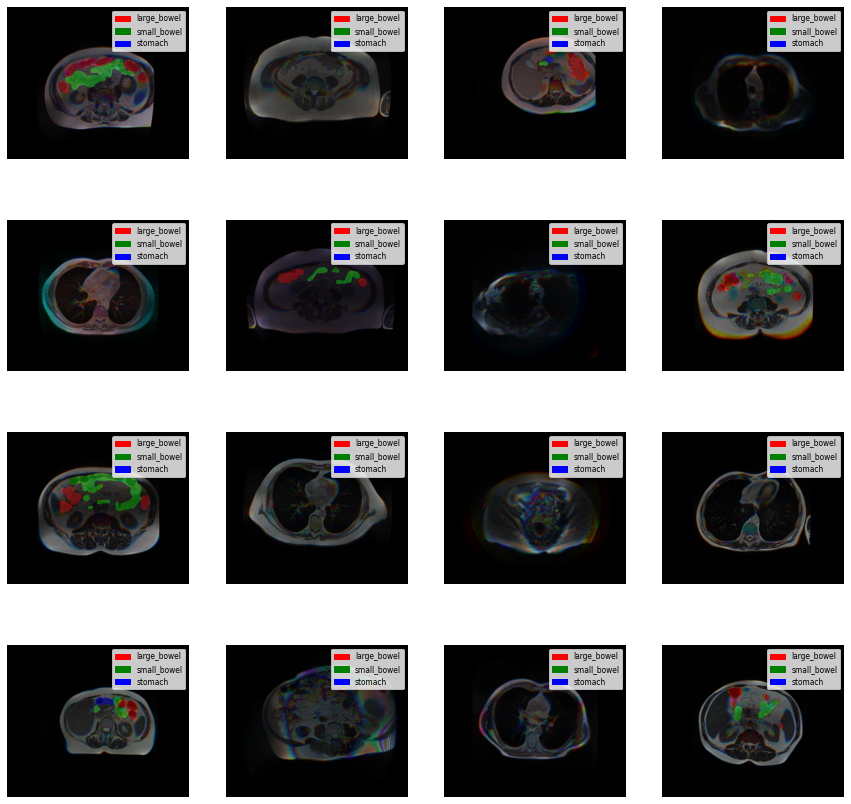

In [21]:
up_size = (320, 384)

tfms = [[partial(get_25D_image, up_size=up_size), PILImage.create],
        [partial(get_mask, up_size=up_size), PILMask.create]]
    
dsets = Datasets(train_df, tfms)

dls = dsets.dataloaders(bs=16, after_item=[ToTensor], after_batch=[IntToFloatTensor])

# Now let's see if our visualization works
dls.show_batch(nrows=4, ncols=4, max_n=16, figsize=(15, 15))

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


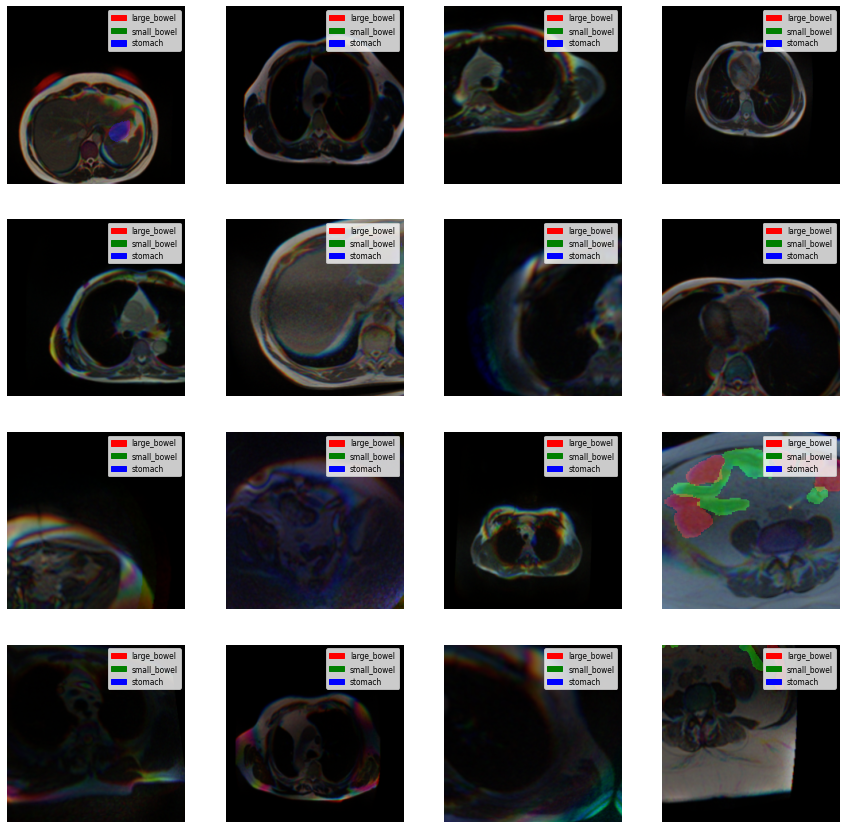

In [22]:
up_size = (320, 384)

tfms = [[partial(get_25D_image, up_size=up_size), PILImage.create],
        [partial(get_mask, up_size=up_size), PILMask.create]]

splits = RandomSplitter()(train_df)
dsets = Datasets(train_df, tfms, splits=splits)

dls = dsets.dataloaders(bs=16, after_item=[RandomResizedCrop(224), ToTensor], after_batch=[IntToFloatTensor, *aug_transforms(mult=0.8)])

# Now let's see if our visualization works
dls.show_batch(nrows=4, ncols=4, max_n=16, figsize=(15, 15))

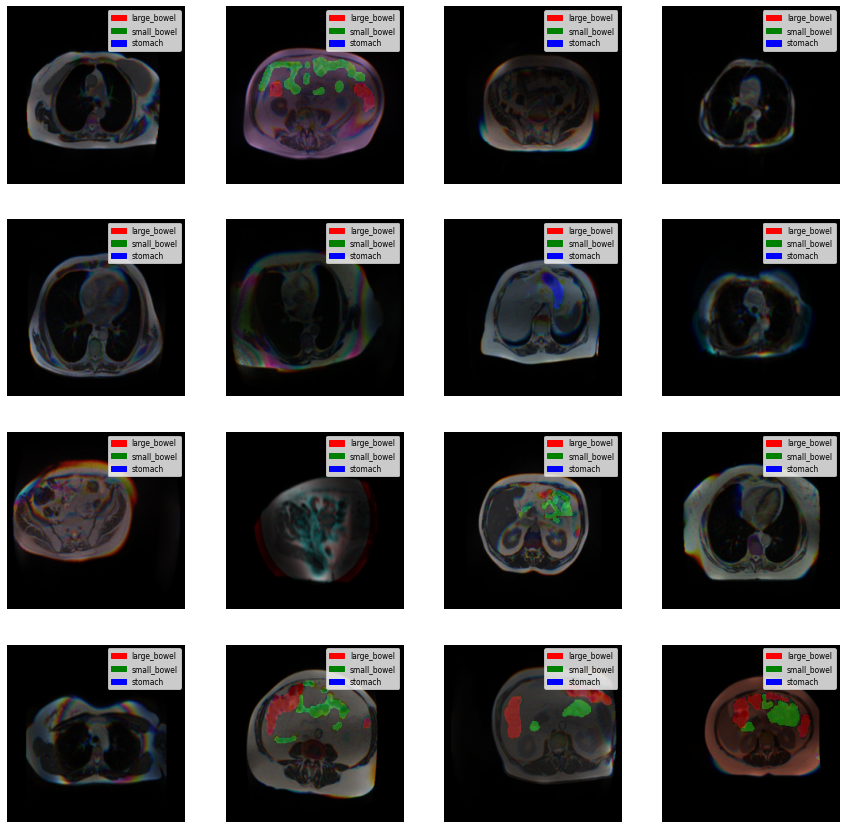

In [33]:
# Check validation set
dls.valid.show_batch(nrows=4, ncols=4, max_n=16, figsize=(15, 15))

In [23]:
import albumentations as A

def get_train_aug(img_size, crop=0.9, p=0.4):
    crop_size = round(img_size[0]*crop)
    return A.Compose([
            A.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
            A.HorizontalFlip(p=p),
            A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=p),
            A.CoarseDropout(
                max_holes=8, min_holes=8,
                max_height=crop_size//10, max_width=crop_size//10,
                min_height=4, min_width=4, mask_fill_value=0, p=0.2*p),
            A.ShiftScaleRotate(
                shift_limit=0.0625, scale_limit=0.2, rotate_limit=25,
                interpolation=cv2.INTER_AREA, p=p),
            A.HorizontalFlip(p=0.5*p),
            A.OneOf([
                A.MotionBlur(p=0.2*p),
                A.MedianBlur(blur_limit=3, p=0.1*p),
                A.Blur(blur_limit=3, p=0.1*p),
            ], p=0.2*p),
            A.GaussNoise(var_limit=0.001, p=0.2*p),
            A.OneOf([
                A.OpticalDistortion(p=0.3*p),
                A.GridDistortion(p=0.1*p),
                A.PiecewiseAffine(p=0.3*p),
            ], p=0.2*p),
            A.OneOf([
                A.Sharpen(p=0.2*p),
                A.Emboss(p=0.2*p),
                A.RandomBrightnessContrast(p=0.2*p),
            ]),
        ])


def get_test_aug(img_size, crop=0.9):
    crop_size = round(crop*img_size[0])
    return  A.Compose([
        A.CenterCrop(height=crop_size, width=crop_size),
    ])

In [24]:
import cv2

class AlbumentationsTransform(ItemTransform, RandTransform):
    split_idx, order = None, 2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx): self.idx = split_idx
    
    def encodes(self, x):
        if len(x) > 1:
            img, mask = x
            if self.idx == 0:
                aug = self.train_aug(image=np.array(img), mask=np.array(mask))    
            else:
                aug = self.valid_aug(image=np.array(img), mask=np.array(mask))
            return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
        else:
            img = x[0]
            aug = self.valid_aug(image=np.array(img))
            return PILImage.create(aug["image"])

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


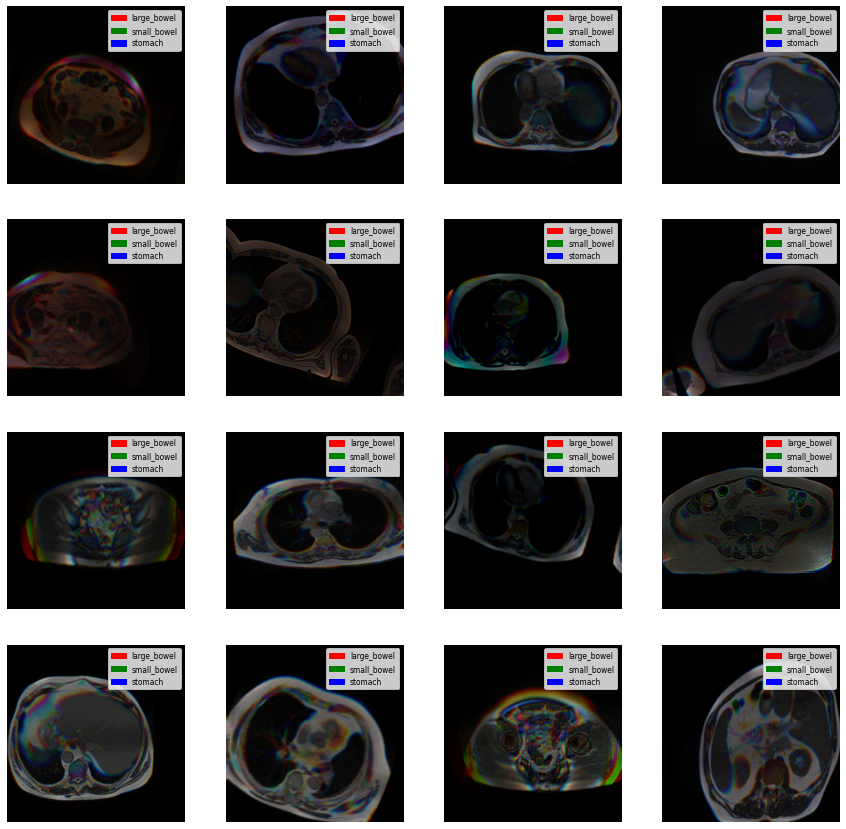

In [25]:
# Let's take a sample of the training dataframe since we aren't going to use it right now 
# in anything more than demonstration

dev_df = train_df.sample(frac=0.2)


up_size = (320, 384)

tfms = [[partial(get_25D_image, up_size=up_size), PILImage.create],
        [partial(get_mask, up_size=up_size), PILMask.create]]

splits = RandomSplitter()(dev_df)
dsets = Datasets(train_df, tfms, splits=splits)

albu_aug = AlbumentationsTransform(get_train_aug(up_size), get_test_aug(up_size))

dls = dsets.dataloaders(bs=16, after_item=[albu_aug, ToTensor], after_batch=[IntToFloatTensor(div_mask=255), 
                                                                             Normalize.from_stats(*imagenet_stats)])

# Now let's see if our visualization works
dls.show_batch(nrows=4, ncols=4, max_n=16, figsize=(15, 15))

In [26]:
from scipy.spatial.distance import directed_hausdorff


def dice_coeff_adj(inp, targ):
    inp = np.where(sigmoid(inp).cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    eps = 1e-5
    dice_scores = []
    for i in range(targ.shape[0]):
        dice_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            I = (targ[i, j] * inp[i, j]).sum()
            U =  targ[i, j].sum() + inp[i, j].sum()
            dice_i.append((2.*I)/(U+eps))
        if dice_i:
            dice_scores.append(np.mean(dice_i))
    
    if dice_scores:
        return np.mean(dice_scores)
    else:
        return 0
    
    
def hd_dist_per_slice(inp, targ, seed):    
    inp = np.argwhere(inp) / np.array(inp.shape)
    targ = np.argwhere(targ) / np.array(targ.shape)
    haussdorf_dist = 1 - directed_hausdorff(inp, targ, seed)[0]
    return haussdorf_dist if haussdorf_dist > 0 else 0

def hd_dist_adj(inp, targ, seed=42):
    inp = np.where(sigmoid(inp).cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    hd_scores = []
    for i in range(targ.shape[0]):
        hd_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            hd_i.append(hd_dist_per_slice(inp[i, j], targ[i, j], seed))
        if hd_i:
            hd_scores.append(np.mean(hd_i))
    if hd_scores:
        return np.mean(hd_scores)
    else:
        return 0

def custom_metric_adj(inp, targ, seed=42):
    hd_score_per_batch = hd_dist_adj(inp, targ, seed)
    dice_score_per_batch = dice_coeff_adj(inp, targ)
    
    return 0.4*dice_score_per_batch + 0.6*hd_score_per_batch

In [27]:
# Loss functions
class DiceBCEModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            bce_loss = nn.BCEWithLogitsLoss()(inp, targ)
            inp = torch.sigmoid(inp)
            
            
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        
        return 0.5*(1 - dice) + 0.5*bce_loss


class DiceBCELoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, thresh=0.5, **kwargs):
        super().__init__(DiceBCEModule, *args, eps=eps, from_logits=from_logits, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

# Source: https://www.kaggle.com/code/thedrcat/focal-multilabel-loss-in-pytorch-explained/notebook
def focal_binary_cross_entropy(logits, targets, gamma=2, n=3):
    p = torch.sigmoid(logits)
    p = torch.where(targets >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = n*loss.mean()
    return loss

class DiceFocalModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, ws=[0.5, 0.5], gamma=2, n=3):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            focal_loss = focal_binary_cross_entropy(inp, targ, self.gamma, self.n)
            inp = torch.sigmoid(inp)
            
            
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        
        return self.ws[0]*(1 - dice) + self.ws[1]*focal_loss
    
class DiceFocalLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, ws=[0.5, 0.5], gamma=2, n=3, thresh=0.5, **kwargs):
        super().__init__(DiceFocalModule, *args, eps=eps, from_logits=from_logits, ws=ws, gamma=gamma, n=n, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

class FocalTverskyLossModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, alpha=0.3, beta=0.7, gamma=3/4):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            inp = torch.sigmoid(inp)
            
        inp_0, inp_1 = inp, 1 - inp
        targ_0, targ_1 = targ, 1 - targ
            
        num = (inp_0 * targ_0).sum() 
        denom = num + (self.alpha * (inp_0 * targ_1).sum()) + (self.beta * (inp_1 * targ_0).sum()) + self.eps
        loss = 1 - (num / denom)
        return loss**self.gamma 
    
class FocalTverskyLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, alpha=0.3, beta=0.7, gamma=3/4, thresh=0.5, **kwargs):
        super().__init__(FocalTverskyLossModule, *args, eps=eps, from_logits=from_logits, alpha=alpha, beta=beta, gamma=gamma, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

def focal_binary_cross_entropy(logits, targets, gamma=2, n=3):
    p = torch.sigmoid(logits)
    p = torch.where(targets >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = n*loss.mean()
    return loss

class ComboModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, ws=[2, 3, 1], gamma=2, n=3):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            focal_loss = focal_binary_cross_entropy(inp, targ, self.gamma, self.n)
            bce_loss = nn.BCEWithLogitsLoss()(inp, targ)
            inp = torch.sigmoid(inp)
                
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        
        return self.ws[0]*(1 - dice) + self.ws[1]*focal_loss + self.ws[2]*bce_loss
    
class ComboLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, ws=[2, 3, 1], gamma=2, n=3, thresh=0.5, **kwargs):
        super().__init__(ComboModule, *args, eps=eps, from_logits=from_logits, ws=ws, gamma=gamma, n=n, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

In [28]:
import segmentation_models_pytorch as smp

def build_model(encoder_name, in_c=3, classes=3, weights="imagenet"):
    model = smp.Unet(
        encoder_name=encoder_name,      
        encoder_weights=weights,     
        in_channels=in_c,                
        classes=classes,        
        activation=None
    )
    return model

In [29]:
def smp_splitter(model):
    model_layers = list(model.children())
    encoder_params = params(model_layers[0])
    decoder_params = params(model_layers[1]) + params(model_layers[2])
    return L(encoder_params, decoder_params)

In [30]:
model = build_model('efficientnet-b0')
metrics = [dice_coeff_adj, hd_dist_adj, custom_metric_adj]
loss_func = ComboLoss()
splitter = smp_splitter

In [31]:
learn = Learner(dls, model, metrics=metrics, loss_func=loss_func, splitter=splitter).to_fp16()
learn.freeze()

In [32]:
learn.fine_tune(1, 1e-2)

C:\Users\shubh\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\shubh\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\cuda\amp\grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [33]:
learn.export('test_model.pkl')

In [34]:
import timm

def timm_model_sizes(encoder, img_size):
    sizes = []
    for layer in encoder.feature_info:
        sizes.append(torch.Size([1, layer['num_chs'], img_size[0]//layer['reduction'], img_size[1]//layer['reduction']]))
    return sizes


def get_timm_output_layers(encoder):
    outputs = []
    for layer in encoder.feature_info:
        # Converts 'blocks.0.0' to ['blocks', '0', '0']
        attrs = layer['module'].split('.')
        output_layer = getattr(encoder, attrs[0])[int(attrs[1])][int(attrs[2])]
        outputs.append(output_layer)
    return outputs


class DynamicTimmUnet(SequentialEx):
    "Create a U-Net from a given architecture in timm."
    def __init__(self, encoder, n_out, img_size, blur=False, blur_final=True, self_attention=False,
                 y_range=None, last_cross=True, bottle=False, act_cls=defaults.activation,
                 init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
        imsize = img_size
        sizes = timm_model_sizes(encoder, img_size)
        sz_chg_idxs = list(reversed(range(len(sizes))))
        outputs = list(reversed(get_timm_output_layers(encoder)))
        self.sfs = hook_outputs(outputs, detach=False)
        
        # cut encoder
        encoder = nn.Sequential(*list(encoder.children()))[:-5]
        
        x = dummy_eval(encoder, imsize).detach()

        ni = sizes[-1][1]
        middle_conv = nn.Sequential(ConvLayer(ni, ni*2, act_cls=act_cls, norm_type=norm_type, **kwargs),
                                    ConvLayer(ni*2, ni, act_cls=act_cls, norm_type=norm_type, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, BatchNorm(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sz_chg_idxs):
            not_final = i!=len(sz_chg_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sizes[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sz_chg_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
                                   act_cls=act_cls, init=init, norm_type=norm_type, **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sizes[0][-2:]: layers.append(PixelShuffle_ICNR(ni, act_cls=act_cls, norm_type=norm_type))
        layers.append(ResizeToOrig())
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(ResBlock(1, ni, ni//2 if bottle else ni, act_cls=act_cls, norm_type=norm_type, **kwargs))
        layers += [ConvLayer(ni, n_out, ks=1, act_cls=None, norm_type=norm_type, **kwargs)]
        apply_init(nn.Sequential(layers[3], layers[-2]), init)
        #apply_init(nn.Sequential(layers[2]), init)
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        layers.append(ToTensorBase())
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()
            
            
def dynamic_unet_splitter(model):
    return L(model[0], model[1:]).map(params)


In [35]:
dls = dsets.dataloaders(bs=16, after_item=[albu_aug, ToTensor],
                        after_batch=[IntToFloatTensor(div_mask=255), Normalize.from_stats(*imagenet_stats)])

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


C:\Users\shubh\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [39]:
img_size = [round(0.9*320) for _ in range(2)]

encoder = timm.create_model('efficientnet_b0', pretrained=True)

# Let's use self attentions and Mish activation function 
model = DynamicTimmUnet(encoder, 3, img_size, self_attention=True, act_cls=Mish)

# We'll also use ranger optimizer with is RAdam with Lookahead
learn = Learner(dls, model, metrics=metrics, loss_func=loss_func, splitter=dynamic_unet_splitter, opt_func=ranger).to_fp16()
learn.freeze()

RuntimeError: unexpected EOF, expected 24659 more bytes. The file might be corrupted.

C:\Users\shubh\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\shubh\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\cuda\amp\grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


SuggestedLRs(valley=0.0005754399462603033)

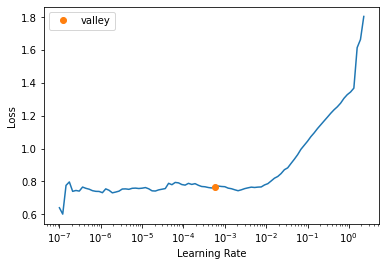

In [40]:
learn.lr_find()

In [42]:
# Let's also use flat cosine annealing lr shceduler
lr = 1e-3
learn.fit_flat_cos(1, lr)

In [43]:
learn.unfreeze()
learn.fit_flat_cos(2, slice(lr/400, lr/4))

In [44]:
def create_df(df, fnames):
    df = df.copy()
    df = df.pivot(index='id', columns='class', values='segmentation').reset_index()
    
    df['partial_fname'] = df.id
    fname_df = pd.DataFrame({'partial_fname': [f'{fname.parts[-3]}_slice_{fname.parts[-1][6:10]}' for fname in fnames],
                             'fname': fnames})

    df = df.merge(fname_df, on='partial_fname').drop('partial_fname', axis=1)

    df['case_id'] = df.id.apply(lambda x: x.split('_')[0])
    df['day_num'] = df.id.apply(lambda x: x.split('_')[1])

    df['slice_w'] = df["fname"].apply(lambda x: int(str(x)[:-4].rsplit("_",4)[1]))
    df['slice_h'] = df["fname"].apply(lambda x: int(str(x)[:-4].rsplit("_",4)[2]))
    
    channels = 3
    stride = 2
    for j, i in enumerate(range(-1*(channels-channels//2-1), channels//2+1)):
        method = 'ffill'
        if i <= 0: method = 'bfill'
        df[f'fname_{j:02}'] = df.groupby(['case_id', 'day_num'])['fname'].shift(stride*-i).fillna(method=method)

    df['fnames'] = df[[f'fname_{j:02d}' for j in range(channels)]].values.tolist()
    
    return df

In [ ]:
data_path = '../input/uw-madison-gi-tract-image-segmentation/'

train_path = Path(data_path+'train')
test_path = Path(data_path+'test')

train_fnames = get_image_files(train_path)
test_fnames = get_image_files(test_path)

sample_submission = pd.read_csv(data_path+'sample_submission.csv')

if sample_submission.shape[0] > 0: 
    test = sample_submission.copy()
else:
    test_fnames = train_fnames
    test_path = train_path
    test = train.copy()
    test = test.sample(frac=1.0, random_state=42)

test_df = create_df(test, test_fnames)